# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

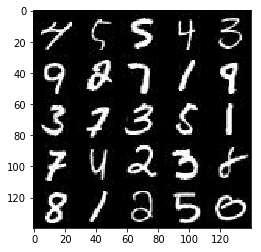

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

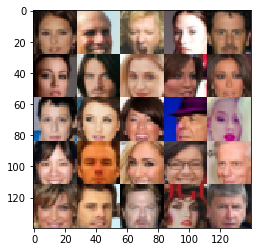

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32, None)

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    #images = images * 2
    with tf.variable_scope('discriminator', reuse=reuse):        
        # Input layer is 28x28x3(CelebA)
        # Input layer is 28x28x1(MNIST)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64 
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.2
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3(CelebA)
        # 28x28x1(MNIST)
        
        #mutiply 0.5 to get the fake input in the range of -0.5 to 0.5
        out = tf.tanh(logits) * 0.5
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8101... Generator Loss: 0.2374
Epoch 1/2... Discriminator Loss: 0.2228... Generator Loss: 6.8884
Epoch 1/2... Discriminator Loss: 0.4627... Generator Loss: 2.1722
Epoch 1/2... Discriminator Loss: 0.0257... Generator Loss: 7.3996
Epoch 1/2... Discriminator Loss: 0.6293... Generator Loss: 2.6234
Epoch 1/2... Discriminator Loss: 1.3360... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 1.8321
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 1.9743
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.2134... Generator Loss: 0.8734


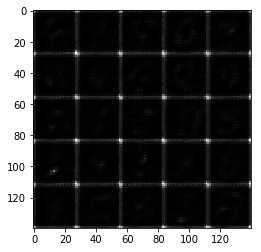

Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 1.6603
Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 0.5594
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 1.4434
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 0.7679
Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 0.3894
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 1.6801
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 0.9427
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.5184
Epoch 1/2... Discriminator Loss: 1.0499... Generator Loss: 0.8612


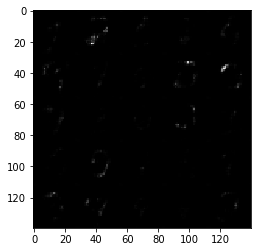

Epoch 1/2... Discriminator Loss: 1.0424... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 0.4897
Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 0.4828
Epoch 1/2... Discriminator Loss: 0.8233... Generator Loss: 1.0795
Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 1.0788... Generator Loss: 0.5848
Epoch 1/2... Discriminator Loss: 0.8953... Generator Loss: 0.9302
Epoch 1/2... Discriminator Loss: 0.8270... Generator Loss: 1.4606
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 0.9538
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 1.0634


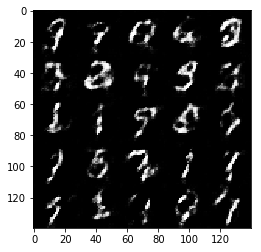

Epoch 1/2... Discriminator Loss: 0.8614... Generator Loss: 1.1172
Epoch 1/2... Discriminator Loss: 1.0788... Generator Loss: 0.7212
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.8032
Epoch 1/2... Discriminator Loss: 1.1713... Generator Loss: 0.5640
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 1.1098
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 0.9798
Epoch 1/2... Discriminator Loss: 0.8919... Generator Loss: 1.0761
Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 1.0300
Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 0.6924
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 1.5045


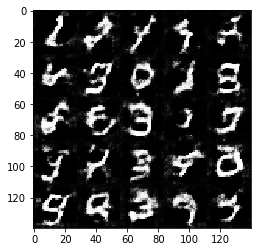

Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 0.8605
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 0.5672
Epoch 1/2... Discriminator Loss: 0.9214... Generator Loss: 1.3138
Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 0.7422
Epoch 1/2... Discriminator Loss: 1.0866... Generator Loss: 1.1406
Epoch 1/2... Discriminator Loss: 1.1477... Generator Loss: 1.5219
Epoch 1/2... Discriminator Loss: 1.0031... Generator Loss: 1.0389
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 0.7168
Epoch 1/2... Discriminator Loss: 1.2661... Generator Loss: 0.4794
Epoch 1/2... Discriminator Loss: 1.1145... Generator Loss: 0.7430


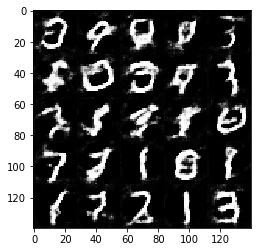

Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 0.8480
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 0.5158
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 0.5568
Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 0.5348
Epoch 1/2... Discriminator Loss: 0.9373... Generator Loss: 1.2402
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 0.5955
Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.5107


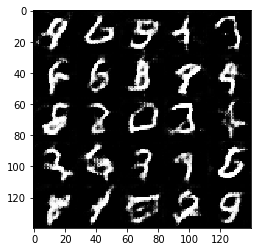

Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 0.5833
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 1.2821
Epoch 1/2... Discriminator Loss: 1.3294... Generator Loss: 0.4153
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.4163
Epoch 1/2... Discriminator Loss: 0.9991... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.0366... Generator Loss: 1.4841
Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 1.0988
Epoch 1/2... Discriminator Loss: 0.8660... Generator Loss: 1.0246
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 0.6316
Epoch 1/2... Discriminator Loss: 1.0474... Generator Loss: 1.7474


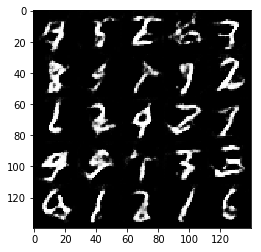

Epoch 1/2... Discriminator Loss: 0.9328... Generator Loss: 1.4447
Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 0.4594
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 0.8012
Epoch 1/2... Discriminator Loss: 1.1020... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 1.5867... Generator Loss: 0.2924
Epoch 1/2... Discriminator Loss: 1.0465... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 1.0286... Generator Loss: 0.6771
Epoch 1/2... Discriminator Loss: 0.7479... Generator Loss: 1.4097
Epoch 1/2... Discriminator Loss: 0.8057... Generator Loss: 0.9104
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.3184


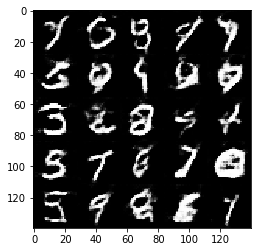

Epoch 1/2... Discriminator Loss: 1.1901... Generator Loss: 2.3947
Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 0.6238
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 0.6517
Epoch 1/2... Discriminator Loss: 1.0014... Generator Loss: 1.3211
Epoch 1/2... Discriminator Loss: 1.2241... Generator Loss: 1.2364
Epoch 1/2... Discriminator Loss: 0.7346... Generator Loss: 1.5830
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 0.8615... Generator Loss: 1.2301
Epoch 1/2... Discriminator Loss: 0.8338... Generator Loss: 0.8086
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 0.5528


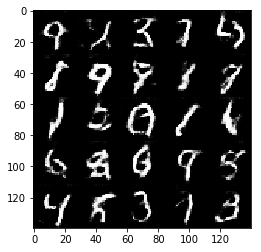

Epoch 1/2... Discriminator Loss: 1.4191... Generator Loss: 0.3846
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 0.5462
Epoch 1/2... Discriminator Loss: 1.0405... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 0.7538... Generator Loss: 1.6034
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.5561
Epoch 2/2... Discriminator Loss: 1.0975... Generator Loss: 0.5896
Epoch 2/2... Discriminator Loss: 0.8299... Generator Loss: 1.2881
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.9217


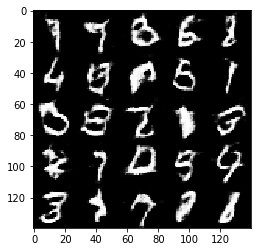

Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.6361
Epoch 2/2... Discriminator Loss: 0.9469... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 0.9789... Generator Loss: 1.1374
Epoch 2/2... Discriminator Loss: 0.9354... Generator Loss: 0.9165
Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 0.6152
Epoch 2/2... Discriminator Loss: 1.0464... Generator Loss: 0.5910
Epoch 2/2... Discriminator Loss: 0.8004... Generator Loss: 1.5905
Epoch 2/2... Discriminator Loss: 1.0464... Generator Loss: 1.5363
Epoch 2/2... Discriminator Loss: 0.7889... Generator Loss: 1.4920
Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 0.4889


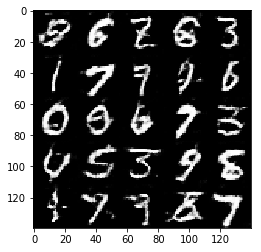

Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 1.4917
Epoch 2/2... Discriminator Loss: 1.0109... Generator Loss: 0.8165
Epoch 2/2... Discriminator Loss: 0.9837... Generator Loss: 0.6473
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 0.9051
Epoch 2/2... Discriminator Loss: 1.7107... Generator Loss: 0.2856
Epoch 2/2... Discriminator Loss: 1.4753... Generator Loss: 0.3682
Epoch 2/2... Discriminator Loss: 0.9837... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 1.1883... Generator Loss: 0.5227
Epoch 2/2... Discriminator Loss: 0.6841... Generator Loss: 1.3949
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 0.8488


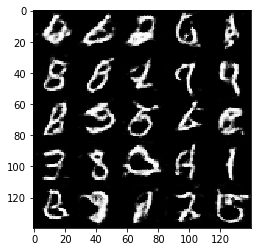

Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 0.5319
Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 0.7220
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 0.8720
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 0.8230
Epoch 2/2... Discriminator Loss: 0.8658... Generator Loss: 1.6462
Epoch 2/2... Discriminator Loss: 0.8569... Generator Loss: 0.9227
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 0.7321... Generator Loss: 1.4484
Epoch 2/2... Discriminator Loss: 0.7292... Generator Loss: 1.1288
Epoch 2/2... Discriminator Loss: 0.5502... Generator Loss: 1.8474


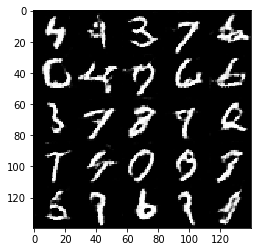

Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 1.5216
Epoch 2/2... Discriminator Loss: 1.0106... Generator Loss: 0.7551
Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 1.0797
Epoch 2/2... Discriminator Loss: 0.6949... Generator Loss: 1.0921
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 1.7770
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 1.2157
Epoch 2/2... Discriminator Loss: 0.7033... Generator Loss: 1.4240
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 0.8566... Generator Loss: 1.5940


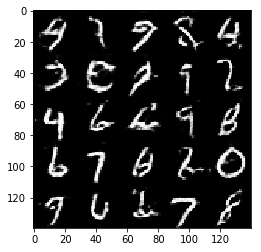

Epoch 2/2... Discriminator Loss: 0.9771... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 0.5031
Epoch 2/2... Discriminator Loss: 0.5754... Generator Loss: 1.5572
Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 0.9498
Epoch 2/2... Discriminator Loss: 0.7292... Generator Loss: 1.5360
Epoch 2/2... Discriminator Loss: 0.6077... Generator Loss: 1.4399
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.3855
Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 0.4958
Epoch 2/2... Discriminator Loss: 0.5578... Generator Loss: 1.4110


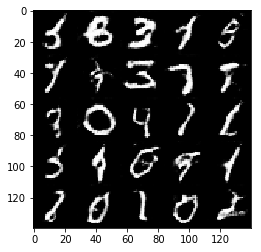

Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 0.9696
Epoch 2/2... Discriminator Loss: 0.6694... Generator Loss: 1.4425
Epoch 2/2... Discriminator Loss: 1.3346... Generator Loss: 1.7661
Epoch 2/2... Discriminator Loss: 0.9783... Generator Loss: 1.2789
Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 0.6756
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.2559
Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 1.0918
Epoch 2/2... Discriminator Loss: 0.9002... Generator Loss: 1.2671
Epoch 2/2... Discriminator Loss: 0.5937... Generator Loss: 1.3184
Epoch 2/2... Discriminator Loss: 0.7432... Generator Loss: 0.9158


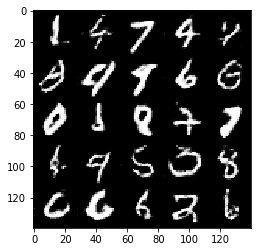

Epoch 2/2... Discriminator Loss: 0.8189... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 0.6094... Generator Loss: 1.2356
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.2537
Epoch 2/2... Discriminator Loss: 0.5752... Generator Loss: 1.5658
Epoch 2/2... Discriminator Loss: 0.8422... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 0.5269... Generator Loss: 2.6070
Epoch 2/2... Discriminator Loss: 0.9300... Generator Loss: 2.1164
Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 0.6524
Epoch 2/2... Discriminator Loss: 1.0618... Generator Loss: 0.6319
Epoch 2/2... Discriminator Loss: 0.8903... Generator Loss: 0.8928


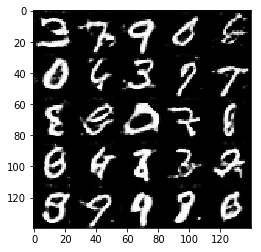

Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 0.8291
Epoch 2/2... Discriminator Loss: 0.8507... Generator Loss: 0.9155
Epoch 2/2... Discriminator Loss: 0.5993... Generator Loss: 1.4205
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 0.7122
Epoch 2/2... Discriminator Loss: 0.7798... Generator Loss: 2.1674
Epoch 2/2... Discriminator Loss: 0.9609... Generator Loss: 0.7052
Epoch 2/2... Discriminator Loss: 0.4542... Generator Loss: 1.9572
Epoch 2/2... Discriminator Loss: 1.6466... Generator Loss: 4.4962
Epoch 2/2... Discriminator Loss: 0.8181... Generator Loss: 0.9957
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 1.7568


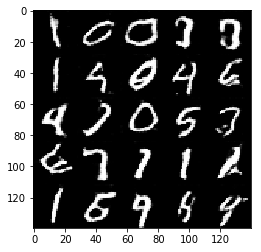

Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 0.6190
Epoch 2/2... Discriminator Loss: 0.7940... Generator Loss: 0.9250
Epoch 2/2... Discriminator Loss: 0.7333... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 0.4185... Generator Loss: 2.1565
Epoch 2/2... Discriminator Loss: 0.8238... Generator Loss: 0.8670
Epoch 2/2... Discriminator Loss: 0.7008... Generator Loss: 2.5291
Epoch 2/2... Discriminator Loss: 0.6705... Generator Loss: 1.2229


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.7336... Generator Loss: 0.4550
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.5899
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 2.5482
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.1840
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 2.4069


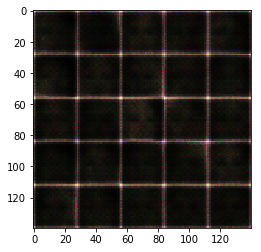

Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 2.9061
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 1.9370
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 4.1477
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 3.4908
Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.7704... Generator Loss: 0.2636
Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 3.6776
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 4.5897
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.1731


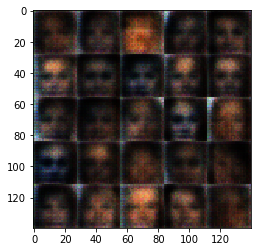

Epoch 1/1... Discriminator Loss: 0.7324... Generator Loss: 1.5772
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 3.9609
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 3.1477
Epoch 1/1... Discriminator Loss: 0.5342... Generator Loss: 1.6495
Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 5.0258
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 1.2205
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 0.3890... Generator Loss: 2.2524
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.5406


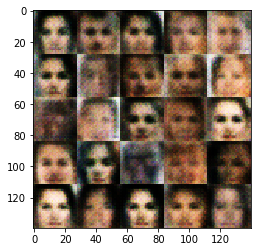

Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 2.9581
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 2.3637... Generator Loss: 0.1510
Epoch 1/1... Discriminator Loss: 0.2232... Generator Loss: 3.0736
Epoch 1/1... Discriminator Loss: 0.4421... Generator Loss: 1.7069
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 2.6680
Epoch 1/1... Discriminator Loss: 1.9882... Generator Loss: 0.2397
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.7722


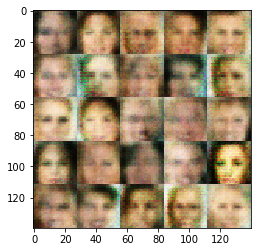

Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 0.5968... Generator Loss: 1.6650
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.3927
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.3661


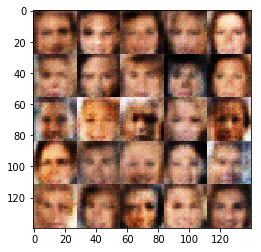

Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.5261
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 2.0329
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 3.7489
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 3.4810
Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 2.4443
Epoch 1/1... Discriminator Loss: 2.1860... Generator Loss: 0.1720
Epoch 1/1... Discriminator Loss: 2.1744... Generator Loss: 0.1993
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 1.6070


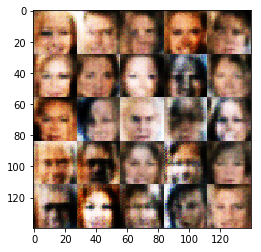

Epoch 1/1... Discriminator Loss: 0.3111... Generator Loss: 2.7893
Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.3120
Epoch 1/1... Discriminator Loss: 0.5672... Generator Loss: 1.3228
Epoch 1/1... Discriminator Loss: 0.3150... Generator Loss: 2.6942
Epoch 1/1... Discriminator Loss: 0.2979... Generator Loss: 1.8632
Epoch 1/1... Discriminator Loss: 0.3541... Generator Loss: 3.5186
Epoch 1/1... Discriminator Loss: 0.1699... Generator Loss: 3.1848
Epoch 1/1... Discriminator Loss: 0.7606... Generator Loss: 3.1082
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 5.9134
Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 1.3362


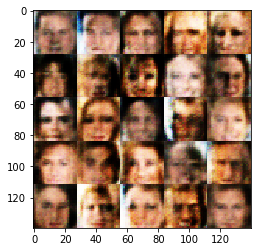

Epoch 1/1... Discriminator Loss: 0.2723... Generator Loss: 2.5683
Epoch 1/1... Discriminator Loss: 0.1112... Generator Loss: 5.6021
Epoch 1/1... Discriminator Loss: 2.0213... Generator Loss: 0.1834
Epoch 1/1... Discriminator Loss: 0.1853... Generator Loss: 2.9578
Epoch 1/1... Discriminator Loss: 0.2428... Generator Loss: 2.5960
Epoch 1/1... Discriminator Loss: 0.2434... Generator Loss: 1.8194
Epoch 1/1... Discriminator Loss: 0.3047... Generator Loss: 1.9099
Epoch 1/1... Discriminator Loss: 0.1268... Generator Loss: 4.3122
Epoch 1/1... Discriminator Loss: 0.1715... Generator Loss: 3.6334
Epoch 1/1... Discriminator Loss: 0.1667... Generator Loss: 2.8587


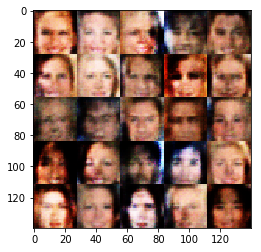

Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 6.1472
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 1.6217
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.3456
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.9414... Generator Loss: 2.6167
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 1.5067
Epoch 1/1... Discriminator Loss: 0.6011... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.4736
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 2.5141


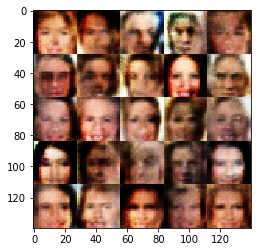

Epoch 1/1... Discriminator Loss: 0.1965... Generator Loss: 6.2053
Epoch 1/1... Discriminator Loss: 0.6372... Generator Loss: 7.1097
Epoch 1/1... Discriminator Loss: 0.2964... Generator Loss: 4.1564
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 1.9651
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 3.8802
Epoch 1/1... Discriminator Loss: 0.3127... Generator Loss: 2.0805
Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 1.6499
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 1.8390
Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 1.5999


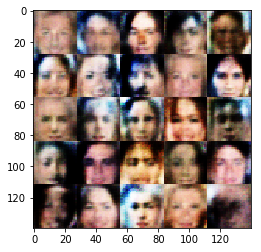

Epoch 1/1... Discriminator Loss: 2.6055... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 0.1788... Generator Loss: 4.9003
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 0.1727... Generator Loss: 3.0735
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 0.2466... Generator Loss: 2.3959
Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 2.8708
Epoch 1/1... Discriminator Loss: 0.2181... Generator Loss: 2.2156
Epoch 1/1... Discriminator Loss: 0.3915... Generator Loss: 6.9121


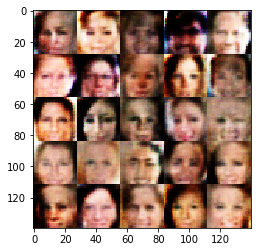

Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 2.8236
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 1.4625
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 2.6447
Epoch 1/1... Discriminator Loss: 0.2738... Generator Loss: 3.8798
Epoch 1/1... Discriminator Loss: 0.3014... Generator Loss: 3.1812
Epoch 1/1... Discriminator Loss: 0.1728... Generator Loss: 2.8701
Epoch 1/1... Discriminator Loss: 1.9901... Generator Loss: 0.2177
Epoch 1/1... Discriminator Loss: 0.4703... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 0.3878... Generator Loss: 3.8023


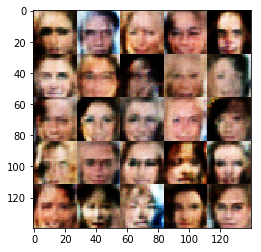

Epoch 1/1... Discriminator Loss: 0.2350... Generator Loss: 3.9956
Epoch 1/1... Discriminator Loss: 0.3226... Generator Loss: 2.1875
Epoch 1/1... Discriminator Loss: 0.3114... Generator Loss: 2.0304
Epoch 1/1... Discriminator Loss: 0.2657... Generator Loss: 2.1385
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 1.6265
Epoch 1/1... Discriminator Loss: 0.2362... Generator Loss: 5.6749
Epoch 1/1... Discriminator Loss: 0.0732... Generator Loss: 5.7725
Epoch 1/1... Discriminator Loss: 0.3135... Generator Loss: 3.7588
Epoch 1/1... Discriminator Loss: 0.1023... Generator Loss: 3.1906
Epoch 1/1... Discriminator Loss: 2.4303... Generator Loss: 2.2432


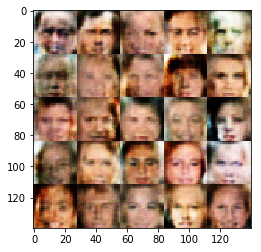

Epoch 1/1... Discriminator Loss: 0.1657... Generator Loss: 3.0798
Epoch 1/1... Discriminator Loss: 0.3067... Generator Loss: 2.2862
Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 1.6405
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 1.4200
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 1.2714
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 5.5152
Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 0.4369... Generator Loss: 1.6965
Epoch 1/1... Discriminator Loss: 0.3692... Generator Loss: 1.5779


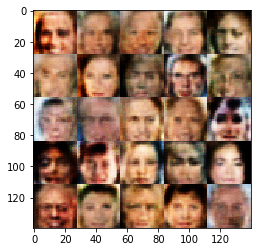

Epoch 1/1... Discriminator Loss: 0.1595... Generator Loss: 3.2069
Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 1.2484
Epoch 1/1... Discriminator Loss: 0.1554... Generator Loss: 3.5366
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 1.7313
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 1.5124
Epoch 1/1... Discriminator Loss: 2.6854... Generator Loss: 0.1000
Epoch 1/1... Discriminator Loss: 0.2644... Generator Loss: 2.7235
Epoch 1/1... Discriminator Loss: 0.4621... Generator Loss: 1.5872
Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 3.6475
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 1.2136


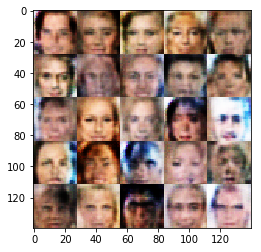

Epoch 1/1... Discriminator Loss: 2.2658... Generator Loss: 2.3570
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.3951
Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 1.7688
Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 0.8346... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 2.1008
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 0.4213... Generator Loss: 7.0194


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.